In [1]:
import datetime
import time
import io

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from astropy.time import Time
from astropy import units as u
from astropy.coordinates import solar_system_ephemeris,get_body_barycentric

import cairo
from PIL import Image
from IPython.display import Image,display,clear_output,SVG

In [2]:
def svd_plane_normal(points):
    # matrix should be in shape:
    #[[x],
    # [y],
    # [z]]

    u,s,vh = np.linalg.svd(points)
    normal = u[:,2]

    return normal

def plane(coords,normal):
    x,y = coords
    return -(normal[0]*x + normal[1]*y)/normal[2]

In [3]:
def centroid(positions):
    return np.sum(positions,axis=0)/positions.shape[0]

In [4]:
def cart_to_polar(x, y, z):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi, z)

def polar_to_cart(rho, phi, z):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y, z)

In [5]:
def get_2d_positions_over_time(start_time,time_delta,n_iter):
    positions_over_time = []
    for i in range(n_iter):
        new_points = get_2d_positions(start_time + time_delta*i)
        positions_over_time.append(new_points)
        
    return positions_over_time

In [6]:
def get_2d_positions(time):
    #time_now = Time(datetime.datetime.utcnow(), scale='utc')
    positions=[]
    body_ignore=['earth-moon-barycenter','moon','pluto']
    for body in solar_system_ephemeris.bodies:
        if body in body_ignore:
            continue
        pos = get_body_barycentric(body, time).xyz.to(u.au)
        positions.append(pos.value)

    positions=np.array(positions)

    points = np.transpose(positions-centroid(positions))
    normal = svd_plane_normal(points)

    a = normal
    b = np.array([1,0,plane((1,0),normal)])
    c = b/np.linalg.norm(b)
    b = np.cross(a,b)

    coord_transform = np.vstack([c,b,a])

    new_points = []
    for row in np.transpose(points):
        new_points.append(np.dot(coord_transform,row+centroid(positions)))

    new_points = np.array(new_points)
        
    return new_points

In [7]:
def draw_image(context, image, top, left, height, width):
    """Draw a scaled image on a given context."""
    image_surface = cairo.ImageSurface.create_from_png(image)
    # calculate proportional scaling
    img_height = image_surface.get_height()
    img_width = image_surface.get_width()
    width_ratio = float(width) / float(img_width)
    height_ratio = float(height) / float(img_height)
    scale_xy = min(height_ratio, width_ratio)
    # scale image and add it
    context.save()
    context.translate(left, top)
    context.scale(scale_xy, scale_xy)
    context.set_source_surface(image_surface,0,0)
    context.paint()
    context.restore()

In [8]:
def draw_border(context):
    context.set_source_rgba(*border_color)
    context.set_line_width(border_stroke_width)
    context.arc(img_size/2,img_size/2, img_size/2 - border_stroke_width, 0, 2*np.pi)
    context.stroke()


In [9]:
def draw_circle(context,radius):
    context.set_line_width(au_grid_stroke_width)
    context.set_dash([7,7])
    context.set_source_rgba(*dashed_line_color)
    context.arc(img_size/2,img_size/2, radius, 0, 2*np.pi)
    context.stroke()
    context.set_dash([1,1])
    context.set_source_rgba(*black_color)
    

In [10]:
def draw_orbit(context,radius):
    context.set_line_width(orbit_stroke_width)
    context.set_dash([1,0])
    context.set_source_rgba(*orbit_line_color)
    context.arc(img_size/2,img_size/2, radius, 0, 2*np.pi)
    context.stroke()
    context.set_source_rgba(*black_color)
    

In [11]:
def draw_label(text,radius):
    context.set_font_size(au_label_font_size)
    (x, y, width, height, dx, dy) = context.text_extents(text)
    context.move_to(img_size/2-width/2,img_size/2+height/2 - radius - height)
    context.set_source_rgba(*white_color)
    context.show_text(text)
    context.stroke()


In [12]:
def draw_sun(context):
    xys = (pos[0,:2]*au_to_pix) + img_size/2

    context.set_source_rgba(*white_color)
        
    text = 'Sun'
    draw_image(context,'./planet_icons/sun.png',xys[0]-default_planet_size/2,xys[1]-default_planet_size/2,default_planet_size,default_planet_size)

    (x, y, width, height, dx, dy) = context.text_extents(text)
    context.move_to(xys[1]-width/2,xys[0]-height/2-12)
    context.show_text(text)

In [13]:
def draw_inner_planets(context):
    
    xys = (pos[1:5,:2]*au_to_pix) + img_size/2
    context.set_source_rgba(*white_color)
    
    planets = [('Mercury','./planet_icons/mercury.png'),
               ('Venus','./planet_icons/venus.png'),
               ('Earth','./planet_icons/earth.png'),
               ('Mars','./planet_icons/mars.png')]
    
    context.set_font_size(planet_name_font_size)
    for ii,(el,(text,planet_png)) in enumerate(zip(xys,planets)):
        draw_image(context,planet_png,el[0]-default_planet_size/2,el[1]-default_planet_size/2,default_planet_size,default_planet_size)

        (x, y, width, height, dx, dy) = context.text_extents(text)
        context.move_to(el[1]-width/2,el[0]-height/2-12)
        context.show_text(text)

In [14]:
def draw_outer_planets(context):
    
    xys = (pos[5:10,:2]*au_to_pix) + img_size/2
    context.set_source_rgba(*white_color)
    
    planets =[('Jupiter','./planet_icons/jupiter.png'),
             ('Saturn','./planet_icons/saturn.png'),
             ('Uranus','./planet_icons/uranus.png'),
             ('Neptune','./planet_icons/neptune.png')]
    
    context.set_font_size(planet_name_font_size)
    for ii,(el,(text,planet_png)) in enumerate(zip(xys,planets)):
        if text == 'Saturn':
            draw_image(context,planet_png,el[0]-default_planet_size/2,el[1]-saturn_width/2,default_planet_size,saturn_width)
        else:
            draw_image(context,planet_png,el[0]-default_planet_size/2,el[1]-default_planet_size/2,default_planet_size,default_planet_size)
        
        (x, y, width, height, dx, dy) = context.text_extents(text)
        context.move_to(el[1]-width/2,el[0]-height/2-12)
        context.show_text(text)


In [15]:
def draw_clear():
    context.set_source_rgba(*white_color)
    context.set_operator(cairo.OPERATOR_CLEAR)
    context.rectangle(0,0,img_size,img_size)
    context.set_operator(cairo.OPERATOR_OVER)

In [16]:
def draw_background(context):
    image_surface = cairo.ImageSurface.create_from_png(background_file)
    context.arc(img_size/2,img_size/2, img_size/2 - border_stroke_width, 0, 2*np.pi)
    context.save()
    context.clip()
    context.set_source_surface(image_surface, 0, 0)    
    context.paint()
    context.restore()

In [17]:
solar_system_ephemeris.set('de438.bsp')

background_file = './planet_icons/star_field.png'
img_size = 500
border_stroke_width = 10
au_grid_stroke_width = 2
orbit_stroke_width = 1
sun_radius = 4

default_planet_size = 25
saturn_width = 975*25/400
au_label_font_size = 14
planet_name_font_size = 14

black_color = [0,0,0,1]
white_color = [1,1,1,1]
border_color = [0,0,0,0.75]
dashed_line_color = white_color
orbit_line_color = [1,1,1,0.6]

sun_color = np.array([255,140,0])/255
mercury_color = np.array([169,169,169])/255
venus_color = np.array([229,195, 98])/255
earth_color = np.array([30,144,255])/255
mars_color = np.array([188,39,50])/255
body_colors = [sun_color,mercury_color,venus_color,earth_color,earth_color,mars_color]

delta = 100
n_iter = 10

In [18]:
au_width = 4
au_to_pix = img_size/au_width

positions_over_time = get_2d_positions_over_time(Time(datetime.datetime.utcnow(), scale='utc'),datetime.timedelta(days=delta),n_iter)
for i,pos in enumerate(positions_over_time):
    surface = cairo.SVGSurface(None, img_size, img_size)
    context = cairo.Context(surface)

    draw_background(context)
    draw_border(context)
    draw_label('1 AU',1*au_to_pix)
    
    draw_orbit(context,1*au_to_pix)

    
    draw_sun(context)
    draw_inner_planets(context)
    #draw_outer_planets(context)
    
    surface.write_to_png(str(i)+'.png')
    draw_clear()

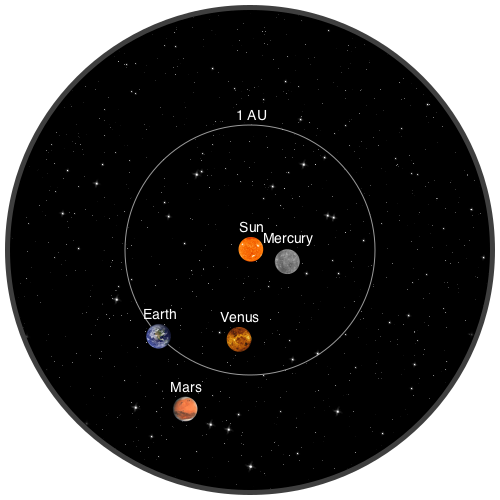

In [19]:
display(Image(filename='0.png'))

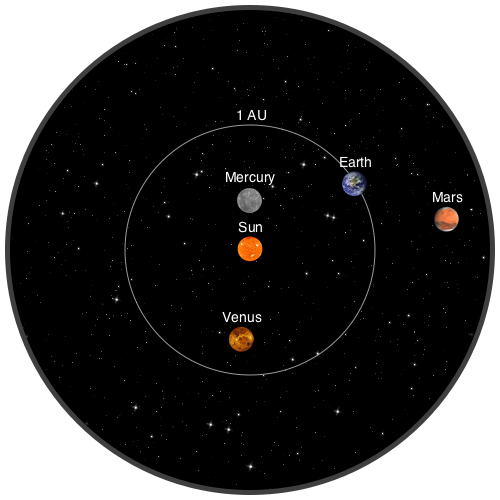

In [20]:
# jank way of displaying a series of png images
for i in range(len(positions_over_time)):
    display(Image(filename=str(i)+'.png'))
    time.sleep(0.01)
    clear_output(wait=True)

In [21]:
au_width = 70
au_to_pix = img_size/au_width

positions_over_time = get_2d_positions_over_time(Time(datetime.datetime.utcnow(), scale='utc'),datetime.timedelta(days=delta),n_iter)
for i,pos in enumerate(positions_over_time):
    surface = cairo.SVGSurface(None, img_size, img_size)
    context = cairo.Context(surface)
    
    draw_background(context)
    
    draw_border(context)
    context.set_font_size(14)
    draw_label('20 AU',20*au_to_pix)
    draw_orbit(context,20*au_to_pix)
    
    draw_sun(context)
    #draw_inner_planets(context)
    draw_outer_planets(context)
    
    surface.write_to_png(str(i)+'.png')
    draw_clear()

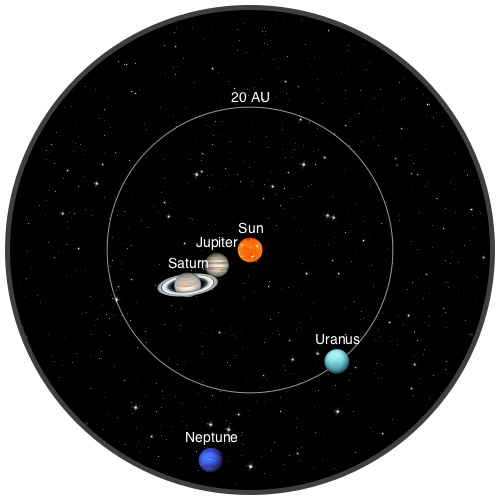

In [22]:
display(Image(filename='0.png'))